In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os
from datetime import datetime
from im2latex import build_inference_model, build_training_model
from data_loader import get_dataset
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from IPython.display import display, Math, Latex, Image
import cv2

print(tf.__version__) # 2.8.0
print(tf.keras.__version__) # 2.8.0
print(np.__version__) # 1.21.6
tf.executing_eagerly() # True


2.8.2
2.8.0
1.21.6


True

In [ ]:
try:
  from google.colab.patches import cv2_imshow
  IN_COLAB = True
except:
  IN_COLAB = False

# Load model

In [ ]:
# saved_model = None
saved_model = r'./checkpoints/cp-0020.ckpt'
im2latex_encoder, im2latex_decoder = build_inference_model(saved_model)

Model loaded from /content/drive/MyDrive/im2markup/model_checkpoints_15/cp-0020.ckpt


# Read test data from npy

In [ ]:
test_images = ['1a6e6aed62.jpg', '1a6a769c1f.jpg', '1a6fe45c04.jpg', '1a0b667b59.jpg', '1a7ff7a2f9.jpg']

In [ ]:
npy_path = r'./datasets/test_buckets.npy'
image_path=r'./images'
test_data = {}
data_dict = np.load(npy_path, allow_pickle=True).tolist()
for keys in data_dict.keys():
    data_list = data_dict[keys]
    for x, y in data_list:
        x = x[:-4] + '.jpg'
        img = cv2.imread(os.path.join(image_path, x), 0)
        img = np.expand_dims(img.astype(np.float32), axis=0)
        img = np.expand_dims(img, axis=-1)
        seq = np.array(y).astype(np.float32)
        test_data[x] = (img, seq[:-1])

In [ ]:
max_seq_len = 150
preds = []
truth = []
imgs = []
for bn, img_name in enumerate(test_images):
  sample = test_data[img_name]
  img = sample[0]
  latex_actual = sample[1]
  encoder_out = im2latex_encoder.predict(img)
  
  token = 500
  latex_pred = []
  decoder_state  = np.zeros([1, 1024])
  while token != 501 and len(latex_pred) <= max_seq_len:
    latex_pred.append(token)
    pred, decoder_state = im2latex_decoder.predict([np.array([latex_pred[-1:]]), 
                                                    encoder_out,
                                                    decoder_state])
    token = np.argmax(pred[0, -1], axis=-1)

  imgs.append(img)
  preds.append(latex_pred)
  truth.append(latex_actual.astype(np.int).tolist())

### Note:

*   501 => END OF SEQUENCE
*   500 => START OF SEQUENCE
*   499 => UNKNOWN
*   0   => null (for padding purpose)



Input image and actual latex seq:


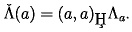

 \check { \Lambda } ( a ) = { ( a , a ) _ { \c H } } \Lambda _ { a } . 

Rendered image and predicted latex seq:


<IPython.core.display.Math object>

 \tilde { \Lambda } ( a ) = ( a , a ) _ { { H } } \Lambda _ { a } . 


Input image and actual latex seq:


 \lbrack x ^ { \mu } , x ^ { \nu } ] _ { * } = i \Theta ^ { \mu \nu } . 

Rendered image and predicted latex seq:


<IPython.core.display.Math object>

 [ x ^ { \mu } , x ^ { \nu } ] _ { * } = i \Theta ^ { \mu \nu } . 


Input image and actual latex seq:


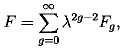

 F = \sum _ { g = 0 } ^ { \infty } \lambda ^ { 2 g - 2 } F _ { g } , 

Rendered image and predicted latex seq:


<IPython.core.display.Math object>

 F = \sum _ { g = 0 } ^ { \infty } \lambda ^ { 2 g - 2 } F _ { g } , 


Input image and actual latex seq:


 \Psi = \operatorname { e x p } \left( i l \varphi \right) R \left( \rho \right) . 

Rendered image and predicted latex seq:


<IPython.core.display.Math object>

 \Psi = \operatorname { e x p } \left( i l \varphi \right) R \left( \rho \right) . 


Input image and actual latex seq:


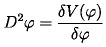

 D ^ { 2 } \varphi = \frac { \delta V ( \varphi ) } { \delta \varphi } 

Rendered image and predicted latex seq:


<IPython.core.display.Math object>

 D ^ { 2 } \varphi = \frac { \delta V ( \varphi ) } { \delta \varphi } 




In [ ]:
vocab_dict = np.load(r'./datasets/properties.npy', allow_pickle=True)
vocab_dict = vocab_dict.tolist()
vocab_map = lambda x: vocab_dict['idx_to_char'][x]
render_latex = lambda x: display(Math(x))

from IPython.display import Image

for img_name, img, actual, pred in zip(test_images, imgs, truth, preds):
  print('Input image and actual latex seq:')
  if IN_COLAB:
    cv2_imshow(img[0])
  else:
    Image(filename=os.path.join(image_path, img_name)) 
  actual = " ".join(list(map(vocab_map, actual))).split('#END')[0].split('#START')[1]
  print(actual, '\n')

  print('Rendered image and predicted latex seq:')
  pred = " ".join(list(map(vocab_map, pred))).split('#END')[0].split('#START')[1]
  render_latex(pred)
  print(pred, '\n\n')

# BLEU score calculation

In [ ]:
batch_size = 20
# validation
# dataset = get_dataset(npy_path=r'./datasets/valid_buckets.npy',
#                         image_path=r'./images',
#                         batch_size=batch_size)
# test
dataset = get_dataset(npy_path=r'./datasets/test_buckets.npy',
                        image_path=r'./images',
                        batch_size=batch_size)

In [ ]:
all_preds = []
all_refs = []
max_seq_len = 200

# for bn, batch in tqdm(enumerate(test_dataset)):
for bn, batch in tqdm(enumerate(dataset)):
  img = batch[0][0]
  latex_actual = batch[0][1]
  encoder_out = im2latex_encoder.predict(img)
  latex_pred = np.ones(shape=[batch_size, 1]) * 500
  decoder_state  = np.zeros([batch_size, 1024])
  eos = False # end of sequence
  while (not eos) and latex_pred.shape[-1] <= max_seq_len:
    pred, decoder_state = im2latex_decoder.predict([latex_pred[:, -1:], 
                                                    encoder_out, 
                                                    decoder_state])
    tokens = np.argmax(pred[:, -1:], axis=-1)
    latex_pred = np.hstack((latex_pred, tokens))
    
    # check if eos(501) is in each row of latex_pred
    eos = (np.full([batch_size, 1], 501) == latex_pred).any(1).all()
  all_preds.append(latex_pred)
  all_refs.append(latex_actual)

419it [48:50,  6.99s/it]


In [ ]:
preds_list = []
refs_list = []
for pred, ref in zip(all_preds, all_refs):
  for i in range(pred.shape[0]):
    end = np.where(pred[i] == 501)[0]
    end = end[0] if (end.size != 0) else None
    preds_list.append([pred[i][:end].astype(np.int32).tolist()])

    end = np.where(ref[i] == 0)[0]
    end = end[0] if (end.size != 0) else None
    refs_list.append(ref[i][:end].numpy().astype(np.int32).tolist())

In [ ]:
# validation dataset - 10340 images
print('BLEU score {:.2f}%'.format(corpus_bleu(preds_list, refs_list) * 100))

BLEU score 84.44%


In [ ]:
# test dataset - 9340 images
print('BLEU score {:.2f}%'.format(corpus_bleu(preds_list, refs_list) * 100))

BLEU score 84.30%
